# LGT FA25 Unit 3 Day 1 Exercises

The goal of today's exercises is to get familiar with the Wilson Dirac operator and how correlation functions are calculated using fermionic observables in lattice QCD. The first part of today's exercise is about implementing the Wilson Dirac operator, inverting it, and then calculating an effective mass for a two point function calculated with the quark propagator you created. The second part is about finding the critical mass of the pion with an improved version of the Wilson Dirac operator, called the Wilson clover operator, and finding the bare quark mass that allows the pions to be massless, indicating the chiral limit of the fermions we implemented. 

Each cell in this notebook will tell you if it needs to be edited or not - some cells will simply need to be run, others will need a few lines of code to be written to work properly. This will be indicated with comments at the top of the cell. These exercises rely heavily on Grid Python Toolkit (GPT), so whenever the lines of code you need to write require some built in GPT function, I will indicate the proper syntax and use. 

## Exercise 1.1: Naive quark propagator [Analytic]

Using the discrete Fourier transform, show
$$
D(p;q)_{ij} = \frac{1}{|\Lambda|}\sum_{n,m\in\Lambda}e^{-ip\cdot na}D_{ij}(n;m)e^{iq\cdot na}
$$

reduces to 

$$
\tilde{D}(p) = mI+ \frac{i}{a}\sum_{\mu=1}^{4}\gamma_{\mu}\sin(p_{\mu}a)
$$

Using the explicit form of the position space Dirac operator

$$
    D(n;m)_{\alpha,a;\beta,b} = \sum_{\mu = 1}^4 (\gamma_{\mu})_{\alpha\beta}\frac{U_{\mu}(n)_{ab}\delta_{n+\hat{\mu},m} - U^{\dagger}_{\mu}(n - \hat{\mu})_{ab}\delta_{n-\hat{\mu},m}}{2a} + m\delta_{\alpha\beta}\delta_{ab}\delta_{n,m}.
$$

## Exercise 1.2: Wilson quark propagator [Analytic]

Repeat exercise 1.1, but include the Wilson term in the position space Dirac operator, transform to momentum space, and invert it to find the Wilson Dirac quark propagator. Comment on the poles of this quark propagator, specifically what happens to the poles corresponding to the doublers? 

The Wilson Dirac operator in position space is given by 

$$
D_W(n;m)_{\alpha,a;\beta,b} = D_{\text{naive}}(n;m)_{{\alpha,a;\beta,b}}-a\sum_{\mu=1}^4\frac{U_{\mu}(n)_{ab}\delta_{n+\hat{\mu},m} - 2\delta_{ab}\delta_{n,m} + U_{-\mu}(n)_{ab}\delta_{n-\hat{\mu},m}}{2a^2}
$$

show that the momentum space operator becomes 

$$
\tilde{D}(p) = mI + \frac{1}{a}\sum_{\mu}\gamma_{\mu}\text{sin}(p_{\mu}a) + I\frac{1}{a}\sum_{\mu}(1-\text{cos}(p_{\mu}a))
$$

and then use the convenient inversion identity:
$$
    \left(aI + i\sum_{\mu=1}^4\gamma_{\mu}b_{\mu}\right)^{-1} = \frac{aI - i\sum_{\mu=1}^4\gamma_{\mu}b_{\mu}}{a^2 + \sum_{\mu=1}^4b^2_{\mu}}
$$

to find the momentum space quark propagator. 

## 2: Pion critical mass

We are going to use GPT to define the Wilson Dirac operator. Note the negative mass input into the definition, this is a bare quark mass, and the goal of this exercise is to see what values of the bare quark mass correspond to massless Wilson fermions corresponding to massless pions.  

The below cell defines this Wilson operator. The function used is called wilson_clover, which corresponds to a cloverleaf improved version, but since we set csw_5 and csw_t to zero, this reduces to the Wilson operator we covered in class. Note the boundary phases, the temporal direction is antiperiodic in time. 

After the operator is defined, we set up and execute the inversion of this operator using the conjugate gradient algorithm, and a preconditioned operator. Preconditioning effectively makes the inversions easier by reducing the condition number of the operator - we will talk about this a bit more in the third lecture. 

The inverted Dirac operator, or quark propagator, is stored in dst. We will use this dst variable as the $D^{-1}(n;m)$ object we saw in class to construct correlation functions. 

On the class github page, there is a single configuration with $N = 8$, $N_t = 32$, and $\beta = 5.5$ which we will use for this exercise. it is called 8c32_b55_su3.200, and the code to load it in is written below. 

In [5]:
#this will not work if Docker is not configured properly
import gpt as g
import numpy as np
import matplotlib.pyplot as plt

SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

Run the below code to generate a small configuration that we will use for our exercise today. This uses the su2 subgroup heatbath algorithm with $\beta=5.5$ and 100 thermalization steps. 

In [6]:
# Do not modify anything in this cell.
Ls = 8
Lt = 32
beta = 5.5
L = [Ls,Ls,Ls,Lt]
grid = g.grid(L, g.single)
grid_eo = g.grid(L, g.single, g.redblack)

rng = g.random("fkbrfr", "vectorized_ranlux24_24_64") #change this?
U = g.qcd.gauge.unit(grid)
Nd = len(U)

# red/black mask
mask_rb = g.complex(grid_eo)
mask_rb[:] = 1
# full mask
mask = g.complex(grid)

# simple plaquette action
def staple(U, mu):
    st = g.lattice(U[0])
    st[:] = 0
    Nd = len(U)
    for nu in range(Nd):
        if mu != nu:
            st += g.qcd.gauge.staple(U, mu, nu) / U[0].otype.Nc
    return st

g.default.push_verbose("su2_heat_bath", False)
markov = g.algorithms.markov.su2_heat_bath(rng)
U = g.qcd.gauge.unit(grid)
plaquette_heatbath = []
for it in range(101):
    plaq = g.qcd.gauge.plaquette(U)
    plaquette_heatbath.append(plaq)
    if it % 100 == 0 and it != 0:
        g.message(f"SU(2)-subgroup heatbath {it} has P = {plaq}")
        Uc = g.copy(U)
    for cb in [g.even, g.odd]:
        mask[:] = 0
        mask_rb.checkerboard(cb)
        g.set_checkerboard(mask, mask_rb)
        
        for mu in range(Nd):
                    st = g.eval(beta * staple(U, mu))
                    markov(U[mu], st, mask)

GPT :       5.730875 s : Initializing gpt.random(fkbrfr,vectorized_ranlux24_24_64) took 3.76701e-05 s
GPT :      65.584452 s : SU(2)-subgroup heatbath 100 has P = 0.5000904401143392


In [8]:
## Do not modify anything in this cell
w = g.qcd.fermion.wilson_clover(U, mass=-0.5, csw_r=0.0, csw_t=0.0, nu=1.0, xi_0=1.0,
                               isAnisotropic=False,
                               boundary_phases=[1,1,1,-1])

src = g.mspincolor(grid)
g.create.point(src, [0, 0, 0, 0])

#set up the conjugate gradient algorithm
inv = g.algorithms.inverter
pc = g.qcd.fermion.preconditioner
g.default.set_verbose("cg_convergence",False)
cg = inv.cg({'eps': 1e-6, "maxiter":1000})
invD = w.propagator(inv.preconditioned(pc.eo1_ne(),cg))

dst2 = g(invD * src)

GPT :     174.281252 s : cg: converged in 33 iterations
GPT :     174.349961 s : cg: converged in 32 iterations
GPT :     174.421271 s : cg: converged in 32 iterations
GPT :     174.489628 s : cg: converged in 32 iterations
GPT :     174.554912 s : cg: converged in 32 iterations
GPT :     174.617480 s : cg: converged in 32 iterations
GPT :     174.676789 s : cg: converged in 32 iterations
GPT :     174.745317 s : cg: converged in 33 iterations
GPT :     174.806153 s : cg: converged in 32 iterations
GPT :     174.865968 s : cg: converged in 33 iterations
GPT :     174.934056 s : cg: converged in 32 iterations
GPT :     174.995773 s : cg: converged in 32 iterations


## Exercise 2.1: Gamma5 Hermiticity of the Wilson Dirac operator

Show the Wilson Dirac operator defined by the 'w' variable is gamma 5 Hermitian. 

Gamma 5 Hermiticity is an important property of the Wilson Dirac operator, where the operator satisfies 
$$
\gamma_5 D_W^{\dagger} \gamma_5 = D_W
$$

In this exercise we can use random fermion fields, defined as 'a' and 'b' to test this property within an inner product. 

In [9]:
#to test gamma-5 Hermiticity, we define two random spincolor fields. These have the spin and color structure of fermion fields, using the grid defined from
#the gauge field as the base object. This ensures we will have no issues with lattice size or precision. 
rng = g.random("test_seed")
a, b = rng.cnormal([g.vspincolor(grid),g.vspincolor(grid)])


'''
Necessary GPT functions
g.inner_product(obj_1, obj_2) - calculates the inner product of the two objects. Returns a scalar.
g.gamma[5] - GPT implementation of the gamma 5 matrix. 

NOTE: GPT multiplication between the gamma matrices and other objects has been defined with the standard '*' operator. 
      you DO NOT need to use the '@' operator. 

NOTE: the fermion operator object we defined with 'w' needs a fermion field to act on, whenever you use it make sure you are using it as (w * c) where c is some spincolor field
'''

# For example, I want to show the norm of the Dirac operator is real, and I do this with the line
norm = g.inner_product(a,g.gamma[5] * w * a)
print(norm)

#to show that the Dirac operator is gamma 5 Hermitian, you will need to write inner producs of the same form, involving both fermion fields.
#the easiest way to do this is to write two inner products and compare them. 
ip_1 = ##enter your code here
ip_2 = ##enter your code here

GPT :     328.476220 s : Initializing gpt.random(test_seed,vectorized_ranlux24_389_64) took 0.000205994 s
(-401.8448075083229+4.435135562630421e-05j)
(2775.208947740205+3564.0769873228687j)
(2775.2087898173445+3564.07702586428j)


## Exercise 2.1: Pion effective mass and correlation function

In the function below, implement the correlation function expression and the effective mass expression so that we can calculate the pion mass for varying quark masses. 

To construct a pion correlator we must define a pion interpolating operator:
$$
\hat{O}_{\pi}(t) = i\sum_{\vec{x}}\overline{u}(\vec{x},t)\gamma_5d(\vec{x},t)
$$
and finding the conjugate of this operator, 
$$
\hat{O}^{\dagger}_{\pi}(t) = i\sum_{\vec{x}}\overline{d}(\vec{x},t)\gamma_5u(\vec{x},t)
$$

Then the correlation function is defined as 
$$
C(t) = \langle\hat{O}_{\pi}(t)\hat{O}_{\pi}^{\dagger}(0)\rangle = \sum_{\vec{x}\vec{y}}\langle \text{Tr}[D^{-1}(\vec{x},t;\vec{y},0) \gamma_5 D^{-1}(\vec{y},0;\vec{x},t) \gamma_5\rangle
$$

And we will use the natural log definition of the effective mass, using two correlator data points, 
$$
m_{eff}(t) = \text{ln}\left(\frac{C_{\pi}(t)}{C_{\pi}(t+1)}\right)
$$

In [10]:
# Modify the function below to calculate the correlator and the effective mass. 

'''
Necessary GPT functions: 
g.adj(M) - ajdoint of the matrix given in the argument
g.trace(M) - takes the spin trace of the object passed in
g.slice(M,axis) - This returns a one dimensional object, the slice of the input along the given axis. Use this to do the sums over the spatial components of the correlator 
'''

#This function calculates the pion effective mass given some bare quark mass. We will use this to see for which bare quark mass the pion mass vanishes. 
def effective_mass_pion_single_config(m):
    #fermion operator with a variable mass
    w = g.qcd.fermion.wilson_clover(U,mass=m, csw_r=0.0,csw_t=0.0, nu=1.0, xi_0=1.0,
                                   isAnisotropic=False,
                                   boundary_phases=[1,1,1,-1])

    #inversion with cg
    invD = w.propagator(inv.preconditioned(pc.eo1_ne(),cg))
    dst = g(invD * src)

    #define the correlation function in this line. no loops necessary, g.slice does the spatial sum for you. 
    Ct = #Correlation function definition here 

    #calculate the effective mass in this line (you will need a for loop) 
    eff_mass = #effective mass defintion here

    #return the effective mass
    return eff_mass 

#this bit runs the inversions and calculations for the masses below. Feel free to edit these. 
emp = {}
for m in [-0.6, -0.7, -0.8, -0.9, -1.0, -1.1, -1.2]:
    emp[m] = effective_mass_pion_single_config(m)

GPT :     356.265900 s : cg: converged in 38 iterations
GPT :     356.338615 s : cg: converged in 37 iterations
GPT :     356.406318 s : cg: converged in 37 iterations
GPT :     356.476487 s : cg: converged in 37 iterations
GPT :     356.546388 s : cg: converged in 38 iterations
GPT :     356.615511 s : cg: converged in 37 iterations
GPT :     356.692168 s : cg: converged in 37 iterations
GPT :     356.763275 s : cg: converged in 38 iterations
GPT :     356.836655 s : cg: converged in 37 iterations
GPT :     356.906670 s : cg: converged in 38 iterations
GPT :     356.975919 s : cg: converged in 37 iterations
GPT :     357.048930 s : cg: converged in 37 iterations
GPT :     357.411455 s : cg: converged in 45 iterations
GPT :     357.496480 s : cg: converged in 43 iterations
GPT :     357.585327 s : cg: converged in 44 iterations
GPT :     357.668330 s : cg: converged in 44 iterations
GPT :     357.748640 s : cg: converged in 44 iterations
GPT :     357.833625 s : cg: converged in 44 ite

## Exercise 2.2: effective pion mass

Plot the effective mass of the pion for one of the bare quark masses you generated data for. 

Find a plateau region to extract a single value of the pion mass from, average the value of the effective mass over these timeslices, and store the pion masses in an array or list. 



In [3]:
#plot the effective mass of one of your pions, decide a good region to average over some number of timeslices. 

In [2]:
quark_masses = []
pion_masses = []

for m in emp:
    quark_masses.append(m)
    pion_masses.append(#your code here - average over as many timeslices as you want)

SyntaxError: incomplete input (2631935310.py, line 6)

## Exercise 2.3: Critical mass
Plot the pion masses you calculated as a function of bare quark mass. Estimate the bare quark mass that you would need in order to see massless pions. 

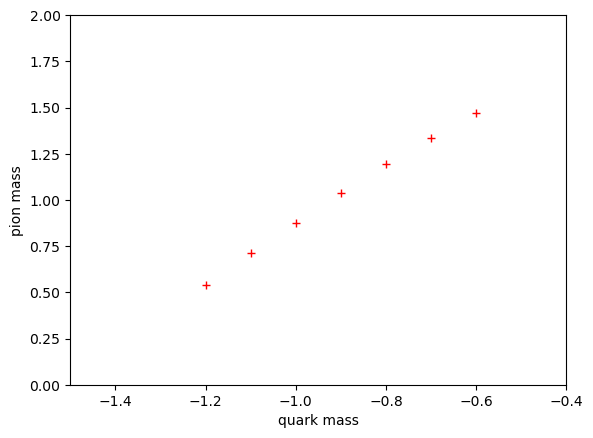

In [11]:
fig2, ax2 = plt.subplots()
ax2.set_ylim(0,2.0)
ax2.set_xlim(-1.5,-0.4)
ax2.set_xlabel("quark mass")
ax2.set_ylabel("pion mass")
ax2.plot(quark_masses, pion_masses, marker='+', ls='',c='red',label="m_pi(m)")